In [1]:
!pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from transformers import Trainer, TrainingArguments

from datasets import load_dataset

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score

In [3]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1)

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [5]:
emotion_dataset = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [6]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [8]:
emotion_dataset["train"]["label"][0]

0

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [9]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [10]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [11]:
tokenizer(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [12]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [15]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [16]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            return_tensors="pt"
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'][0], 
            "attention_mask": tokenizer_output['attention_mask'][0],
            "labels": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [17]:
train_dataset = TweetDataset('train', dataset=emotion_dataset, tokenizer=tokenizer)
valid_dataset = TweetDataset('validation', dataset=emotion_dataset, tokenizer=tokenizer)
test_dataset = TweetDataset('test', dataset=emotion_dataset, tokenizer=tokenizer)

In [18]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
    
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [20]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=len(np.unique(emotion_dataset["train"]["label"]))
)
model = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 81,917,184 trainable parameters


In [22]:
# import wandb
# wandb.login()

# training_args = TrainingArguments(
#     output_dir='./res',          # output directory
#     evaluation_strategy="steps",
#     num_train_epochs=10,              # total number of training epochs
#     per_device_train_batch_size=64,  # batch size per device during training
#     per_device_eval_batch_size=64,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./logs4',            # directory for storing logs
#     logging_steps=10,
#     load_best_model_at_end=True,
# )

# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     # calculate accuracy using sklearn's function
#     acc = accuracy_score(labels, preds)
#     return {
#       'accuracy': acc,
#     }

# trainer = Trainer(
#     model=model,                         # the instantiated Transformers model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=valid_dataset,          # evaluation dataset
#     compute_metrics=compute_metrics,     # the callback that computes metrics of interest
# )

# trainer.train()

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [24]:
from transformers import get_cosine_schedule_with_warmup

num_epochs = 10
lr = 1e-5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(model.parameters(), lr, eps=1e-8)

num_train_steps = len(train_loader) * num_epochs
num_warmup_steps = int(num_train_steps * 0.1) 

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)

In [25]:
def train(dataloader, optimizer, scheduler, device, model):
    model.train()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in tqdm(dataloader):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k, v in batch.items()}
        
        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 

        optimizer.step()
        scheduler.step()
        
        prediction_labels += logits.argmax(axis=-1).flatten().tolist()
    
    return true_labels, prediction_labels, total_loss

def validation(dataloader, device, model):
    model.eval()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in tqdm(dataloader):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()
        
    return true_labels, prediction_labels, total_loss

In [26]:
from sklearn.metrics import classification_report, accuracy_score

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in tqdm(range(num_epochs)):
    y, y_pred, train_loss = train(train_loader, optimizer, lr_scheduler, device, model)
    train_acc = accuracy_score(y, y_pred)
    
    y, y_pred, val_loss = validation(valid_loader, device, model)
    val_acc = accuracy_score(y, y_pred)
    
    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss
    
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)
    
    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}') 

y, y_pred, _ = validation(test_loader, device, model)
test_acc = accuracy_score(y, y_pred)
print(f'test_acc: {test_acc:.3f}') 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0, train_loss: 1.615, train_acc: 0.329, val_loss: 1.635, val_acc: 0.361


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1, train_loss: 1.392, train_acc: 0.457, val_loss: 1.156, val_acc: 0.567


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2, train_loss: 1.009, train_acc: 0.625, val_loss: 0.888, val_acc: 0.667


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.734, train_acc: 0.733, val_loss: 0.791, val_acc: 0.717


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.551, train_acc: 0.799, val_loss: 0.755, val_acc: 0.744


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.432, train_acc: 0.845, val_loss: 0.664, val_acc: 0.775


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.344, train_acc: 0.875, val_loss: 0.653, val_acc: 0.786


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.290, train_acc: 0.895, val_loss: 0.639, val_acc: 0.800


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.256, train_acc: 0.906, val_loss: 0.632, val_acc: 0.804


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.245, train_acc: 0.910, val_loss: 0.629, val_acc: 0.806


  0%|          | 0/32 [00:00<?, ?it/s]

test_acc: 0.800


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [28]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [29]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [30]:
text = emotion_dataset["train"]["text"][44] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


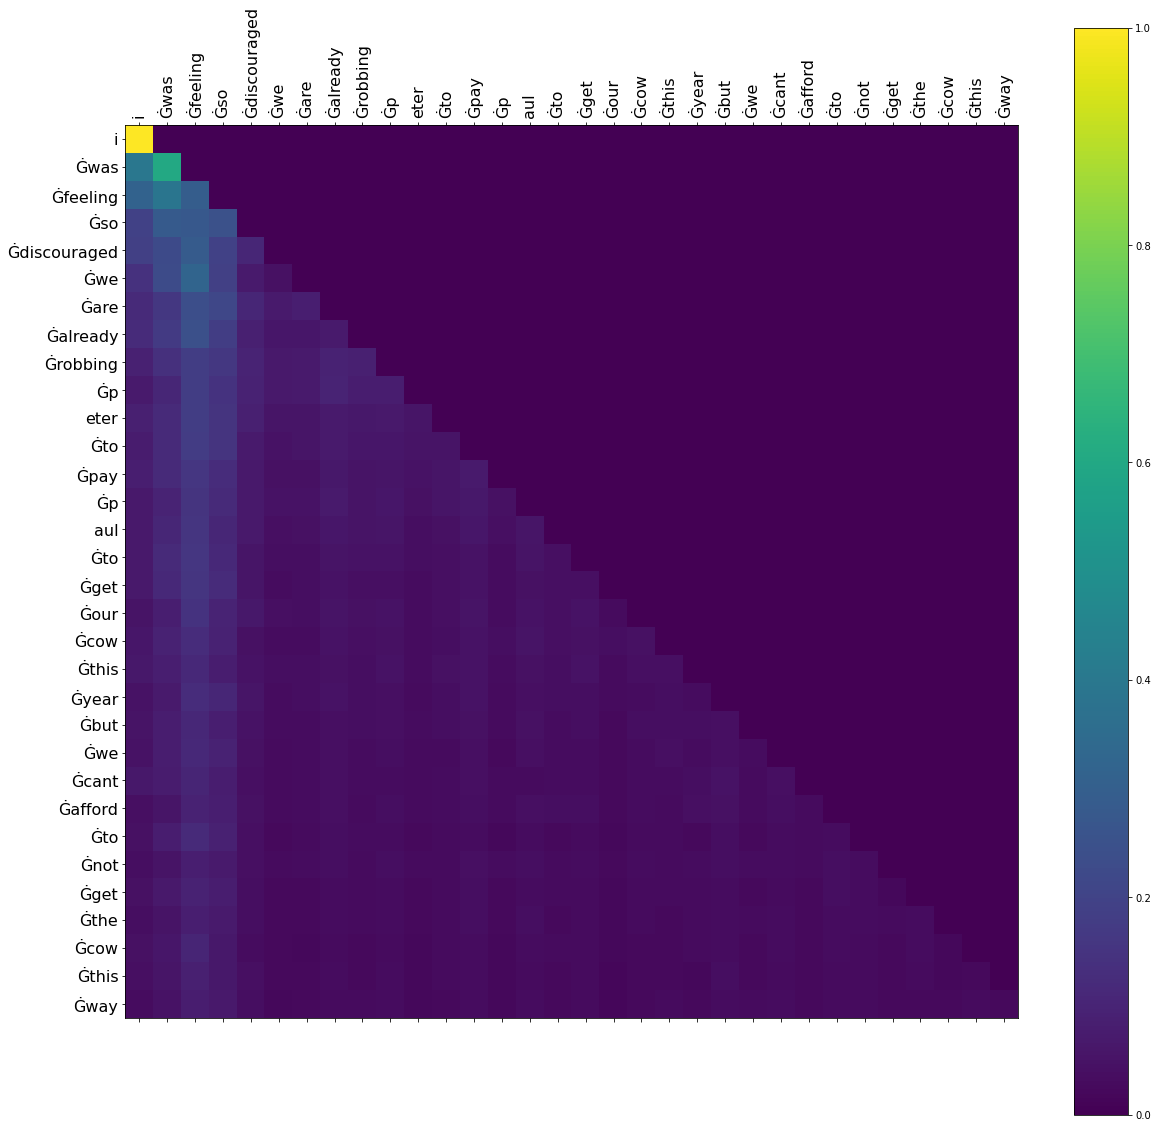

In [31]:
attns = get_attention_matrixes(model, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [32]:
model = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=len(np.unique(emotion_dataset["train"]["label"]))
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr, eps=1e-8)

num_train_steps = len(train_loader) * num_epochs
num_warmup_steps = int(num_train_steps * 0.1) 

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [34]:
all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in tqdm(range(num_epochs)):
    y, y_pred, train_loss = train(train_loader, optimizer, lr_scheduler, device, model)
    train_acc = accuracy_score(y, y_pred)
    
    y, y_pred, val_loss = validation(valid_loader, device, model)
    val_acc = accuracy_score(y, y_pred)
    
    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss
    
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)
    
    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}') 

y, y_pred, _ = validation(test_loader, device, model)
test_acc = accuracy_score(y, y_pred)
print(f'test_acc: {test_acc:.3f}') 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0, train_loss: 2.520, train_acc: 0.291, val_loss: 1.167, val_acc: 0.592


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.747, train_acc: 0.735, val_loss: 0.388, val_acc: 0.867


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.379, train_acc: 0.866, val_loss: 0.277, val_acc: 0.904


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.265, train_acc: 0.903, val_loss: 0.222, val_acc: 0.917


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.215, train_acc: 0.918, val_loss: 0.205, val_acc: 0.918


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.185, train_acc: 0.926, val_loss: 0.187, val_acc: 0.925


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.168, train_acc: 0.932, val_loss: 0.180, val_acc: 0.928


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.158, train_acc: 0.935, val_loss: 0.171, val_acc: 0.928


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.156, train_acc: 0.934, val_loss: 0.170, val_acc: 0.927


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.154, train_acc: 0.934, val_loss: 0.170, val_acc: 0.927


  0%|          | 0/32 [00:00<?, ?it/s]

test_acc: 0.921


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [35]:
text = emotion_dataset["train"]["text"][44] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


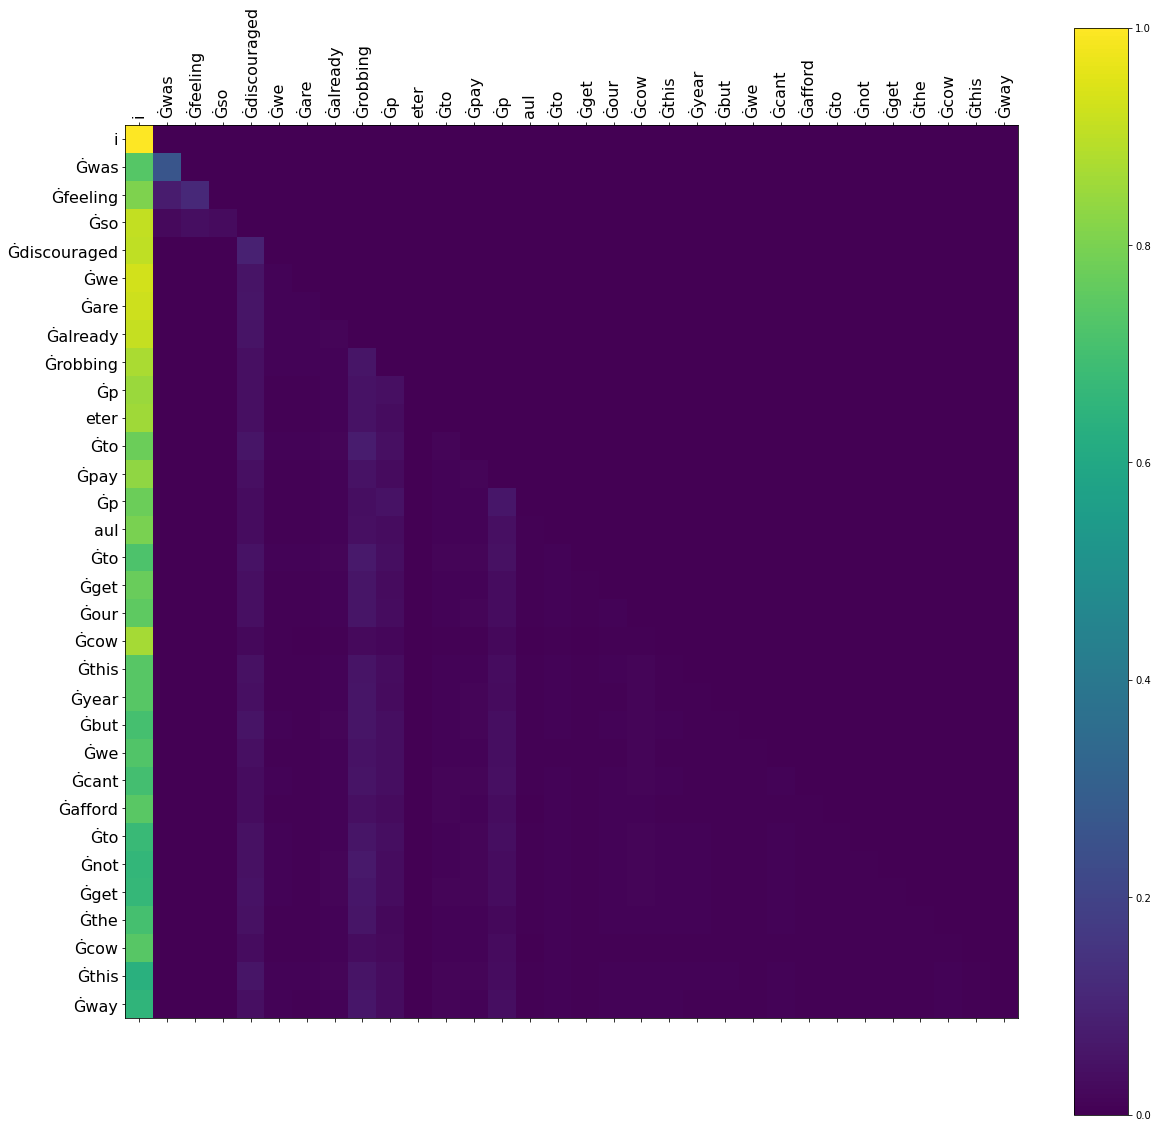

In [36]:
attns = get_attention_matrixes(model, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:

__Какой подход оказался лучше?__ 

* Модель, которая обучалась решать задачу Language Modeling, показала более высокую метрику `accuracy`

__На какие слова модель большего всего обращала внимание?__

* Модель в осовном обращала на первое слово в предложении